## Visualisation of convolutions in keras models

Actually, I was wondering how the kernels in a convolutional network really look like.  As it is difficult to visualize an e.g. 3x3x128 dimensional kernel directly, the output of each kernel for a given picture can be visualized.  My ambitions resulted in 2 function which either show all (or a subset) kernels for a given image or show a small number of kernels for a number of given images.  

The convolutions displayed come from 

> trunc_model = Model(inputs=model.input, outputs=model.get_layer(conv_layer_name).output)
>
> result = trunc_model.predict(batch_image)

After the setup (imports and loading the MNIST dataset), a simple model is loaded and convolutions are displayed.  



In [1]:
# Some standard imports 
import os
# Settings for either running with CUDA vs GPU only (usage of a large models with a small graphic card)
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
import tensorflow
import random
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
print('Keras Version',keras.__version__)
print('Tensorflow Version',tensorflow.__version__)
print('Numpy Version',np.__version__)


c:\users\peter\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras Version 2.1.6
Tensorflow Version 1.8.0
Numpy Version 1.14.0


In [2]:
#  MNIST dataset is used for the toy model
from keras.utils import np_utils

#load the dataset, this time a flatten of the pictures is not not needed
(train_data, train_label), (test_data, test_label) = keras.datasets.mnist.load_data()
# normalize inputs from 0-255 to 0-1
train_data = train_data / 255
test_data = test_data / 255
# one hot encode outputs
train_label= np_utils.to_categorical(train_label)
test_label= np_utils.to_categorical(test_label)

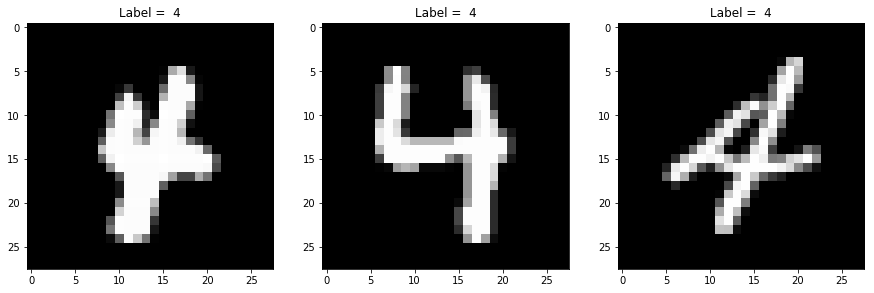

In [3]:
# Just a visualisation of the data just loaded
def create_subplot(plot,data,label):
    rnd = random.randint(0,60000)
    if isinstance(label[rnd],np.ndarray):
        label = np.argmax(label[rnd])
    else:
        label = label[rnd]
    plot.imshow(data[rnd], cmap=plt.get_cmap('gray'))
    plot.set_title('Label =  '+str(label))
    
def show_random_mnist(train_data, train_label):
    f = plt.figure(figsize=(15,5))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    create_subplot(ax,train_data,train_label)
    create_subplot(ax2,train_data,train_label)
    create_subplot(ax3,train_data,train_label)
    plt.show()
    
show_random_mnist(train_data, train_label)

Now a simple toy model is defined for classifying the images.  Parameter were chosen quite arbitrarily, it was not optimized.  

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
test_data =  test_data.reshape(test_data.shape[0], 28, 28, 1).astype('float32')

def createConvModel(input_dim, conv_activation):
    conv_model = Sequential([
        Conv2D(30, (3, 3), input_shape=input_dim, activation=conv_activation, name = "ConvLayer1"),
        Conv2D(30, (3, 3), activation=conv_activation, name = "ConvLayer2"),
        MaxPooling2D(pool_size=(2, 2), name = "PoolingLayer1"),
        Conv2D(15, (3, 3), activation=conv_activation, name = "ConvLayer3"),
        MaxPooling2D(pool_size=(2, 2), name = "PoolingLayer2"),
        Flatten(name = "FlatteningLayer"),
        Dense(128, activation='sigmoid',name = "DenseLayer1"),
        Dense(32, activation='sigmoid',name = "DenseLayer2"),
        Dense(10, activation='softmax',name = "DenseLayer3")
    ])  
    conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return conv_model

In [5]:
conv_model = createConvModel((28,28, 1),conv_activation = 'sigmoid')
conv_model.summary()
# this models takes about 30 min on a decent laptop, alternatively you can load the trained weigths
conv_model.load_weights("models/conv_model_sigmoid.h5")

# history = conv_model.fit(train_data, train_label, epochs=10, batch_size=200, verbose=1)
# conv_model.save_weights("models/conv_model_sigmoid.h5")

# if you want you can evaluate the model,  error rate are about 1 %
# _, test_scores  = conv_model.evaluate(test_data,  test_label,  verbose=1)
# _, train_scores = conv_model.evaluate(train_data, train_label, verbose=1)
# print('test scores', test_scores)
# print('train scores', train_scores)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvLayer1 (Conv2D)          (None, 26, 26, 30)        300       
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 24, 24, 30)        8130      
_________________________________________________________________
PoolingLayer1 (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
ConvLayer3 (Conv2D)          (None, 10, 10, 15)        4065      
_________________________________________________________________
PoolingLayer2 (MaxPooling2D) (None, 5, 5, 15)          0         
_________________________________________________________________
FlatteningLayer (Flatten)    (None, 375)               0         
_________________________________________________________________
DenseLayer1 (Dense)          (None, 128)               48128     
__________

## Displaying convolutions per image

Some comments on the parameters:
* the input_image should have dimensions of either (x,y) for gray scale images of (x,y,3) with np.uint8 values
* use_same_scaling ensures the same scaling of the colorbar for all displayed convvolutions
* if the file_name is not None the convolutions are saved to file, in which case figsize and dpi become important.  



Image shape is (28, 28, 1)


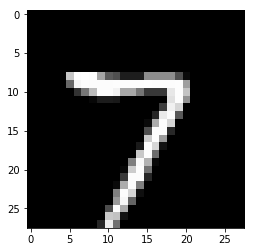

Dimensions of output from layer ConvLayer3 is (None, 10, 10, 15).
This results of 15 plots with dimensions (10,10) each.


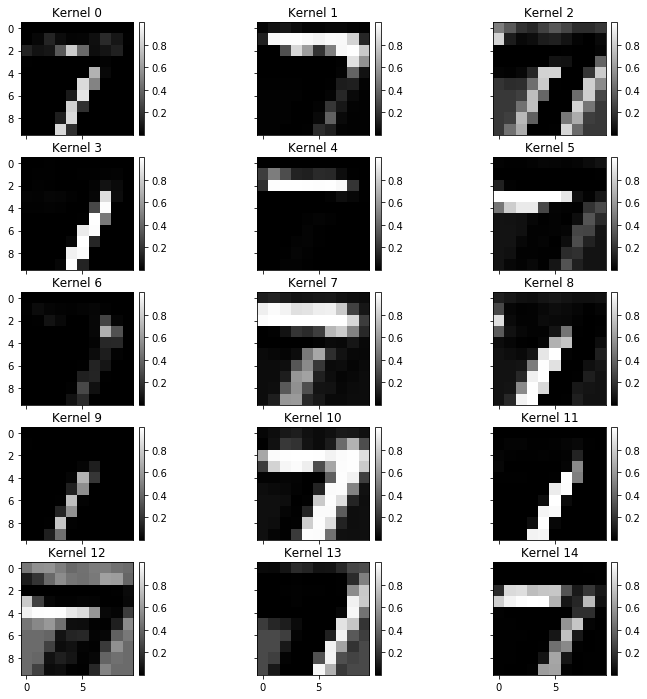

In [15]:
from vis import vis_conv
trunc_model = vis_conv.display_convolutions_per_image(model = conv_model,conv_layer_name = 'ConvLayer3',input_image = train_data[48955], max_cols = None,
                                    max_plots = None, use_same_scaling=True, invert_cmap = False, show_colorbar = True,
                                    figsize = (12,12), dpi = 100, file_name='None')

## Now the with relu activation

Watch the value of the activations, which are not restricted to 0-1 anymore

In [16]:
conv_model = createConvModel((28,28, 1),conv_activation = 'relu')

conv_model.load_weights("models/conv_model_relu.h5")


Image shape is (28, 28, 1)


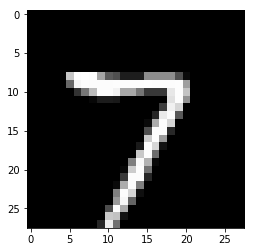

Dimensions of output from layer ConvLayer3 is (None, 10, 10, 15).
This results of 15 plots with dimensions (10,10) each.
From these plots 9 will be displayed


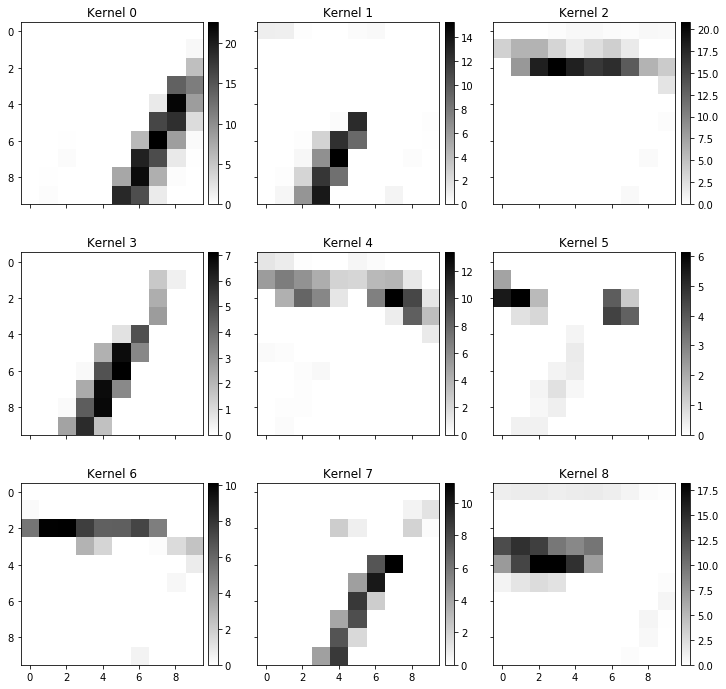

In [17]:
from vis import vis_conv
trunc_model = vis_conv.display_convolutions_per_image(conv_model,'ConvLayer3',train_data[48955], max_cols = None,
                                    max_plots = 9, use_same_scaling=False, invert_cmap = True, show_colorbar = True,
                                    figsize = (12,12), dpi = 100, file_name='mnist_relu_kernels.png')

## Real Test
Now let us look at some models which are shipped with keras and make use of convolutional networks.  Two  models were chosen:
* VGG19, because it is so perfectly linear
* InceptionV3, because it is not

### VGG19

In [19]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model, Input

# we exclude the last dense layers as they are not important for now
input_tensor = Input(shape=(224, 224, 3))  
base_model19 = VGG19(input_tensor=input_tensor, weights='imagenet', include_top = False)
base_model19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The last layer 'block5_pool' was choosen.  As there are 512 kernels the max_plots and max_cols arguments become important.

Note that some of the 32 kernels deliver output near zero, however this kerels change with the input

Image shape is (224, 224, 3)


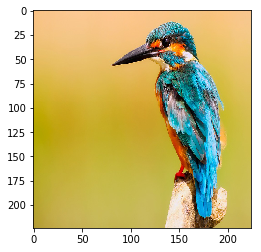

Dimensions of output from layer block5_pool is (None, 7, 7, 512).
This results of 512 plots with dimensions (7,7) each.
From these plots 32 will be displayed


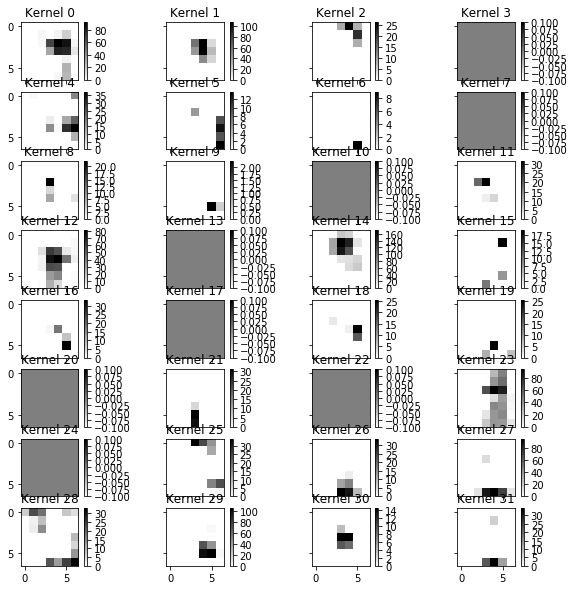

In [20]:
img_path = 'images/bird.jpeg' # other images queen.jpeg, boat.jpeg, car.jpeg
img = image.load_img(img_path, target_size=(224, 224))
x = np.uint8(image.img_to_array(img))
trunc_model = vis_conv.display_convolutions_per_image(base_model19,'block5_pool',x, max_cols = 4,
                                   max_plots = 32, use_same_scaling=False, invert_cmap = True)

### InceptionV3
This models have, mainly to the inception architecture a lot of layers.  Note that for each conv2d_xxx layer there is also a batch_normalization_xxx and a activation_xxx layer.  They can all be displayed.  

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

input_tensor = Input(shape=(224, 224, 3))  
base_model_inception = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top = False)
base_model_inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Image shape is (224, 224, 3)


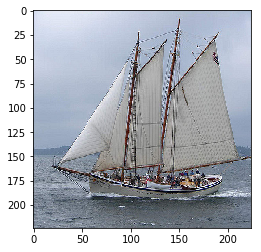

Dimensions of output from layer activation_63 is (None, 12, 12, 192).
This results of 192 plots with dimensions (12,12) each.
From these plots 32 will be displayed


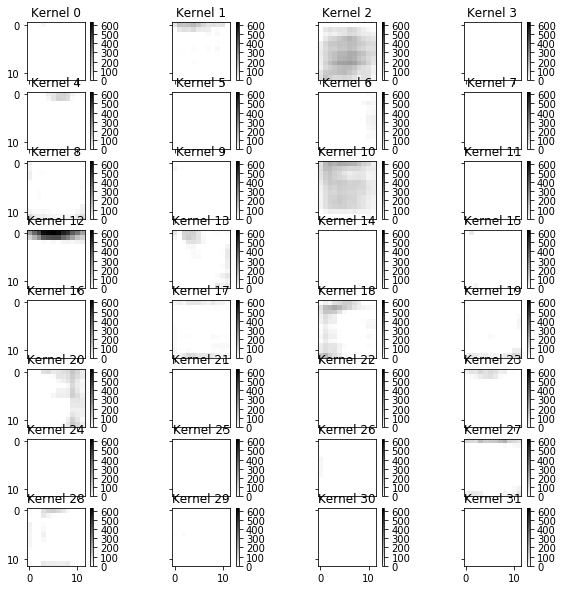

In [25]:
img_path = 'images/boat.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = np.uint8(image.img_to_array(img))
trunc_model = vis_conv.display_convolutions_per_image(base_model_inception,'activation_63',x, max_cols = 4,
                                   max_plots = 32, use_same_scaling=True, invert_cmap = True)

## Comparing convolutions for several images
These method shows the output of a given set of kernels, for the given images.  
Some comments on the parameters:
* filter_indices:  if None 4 kernels are randomly chosen.  
* images can be saved using file_name != None

### Toy example with MNIST

Dimensions of output from layer ConvLayer3 is (None, 10, 10, 15).
5 images will be displayed together with the selected 3 kernel indices


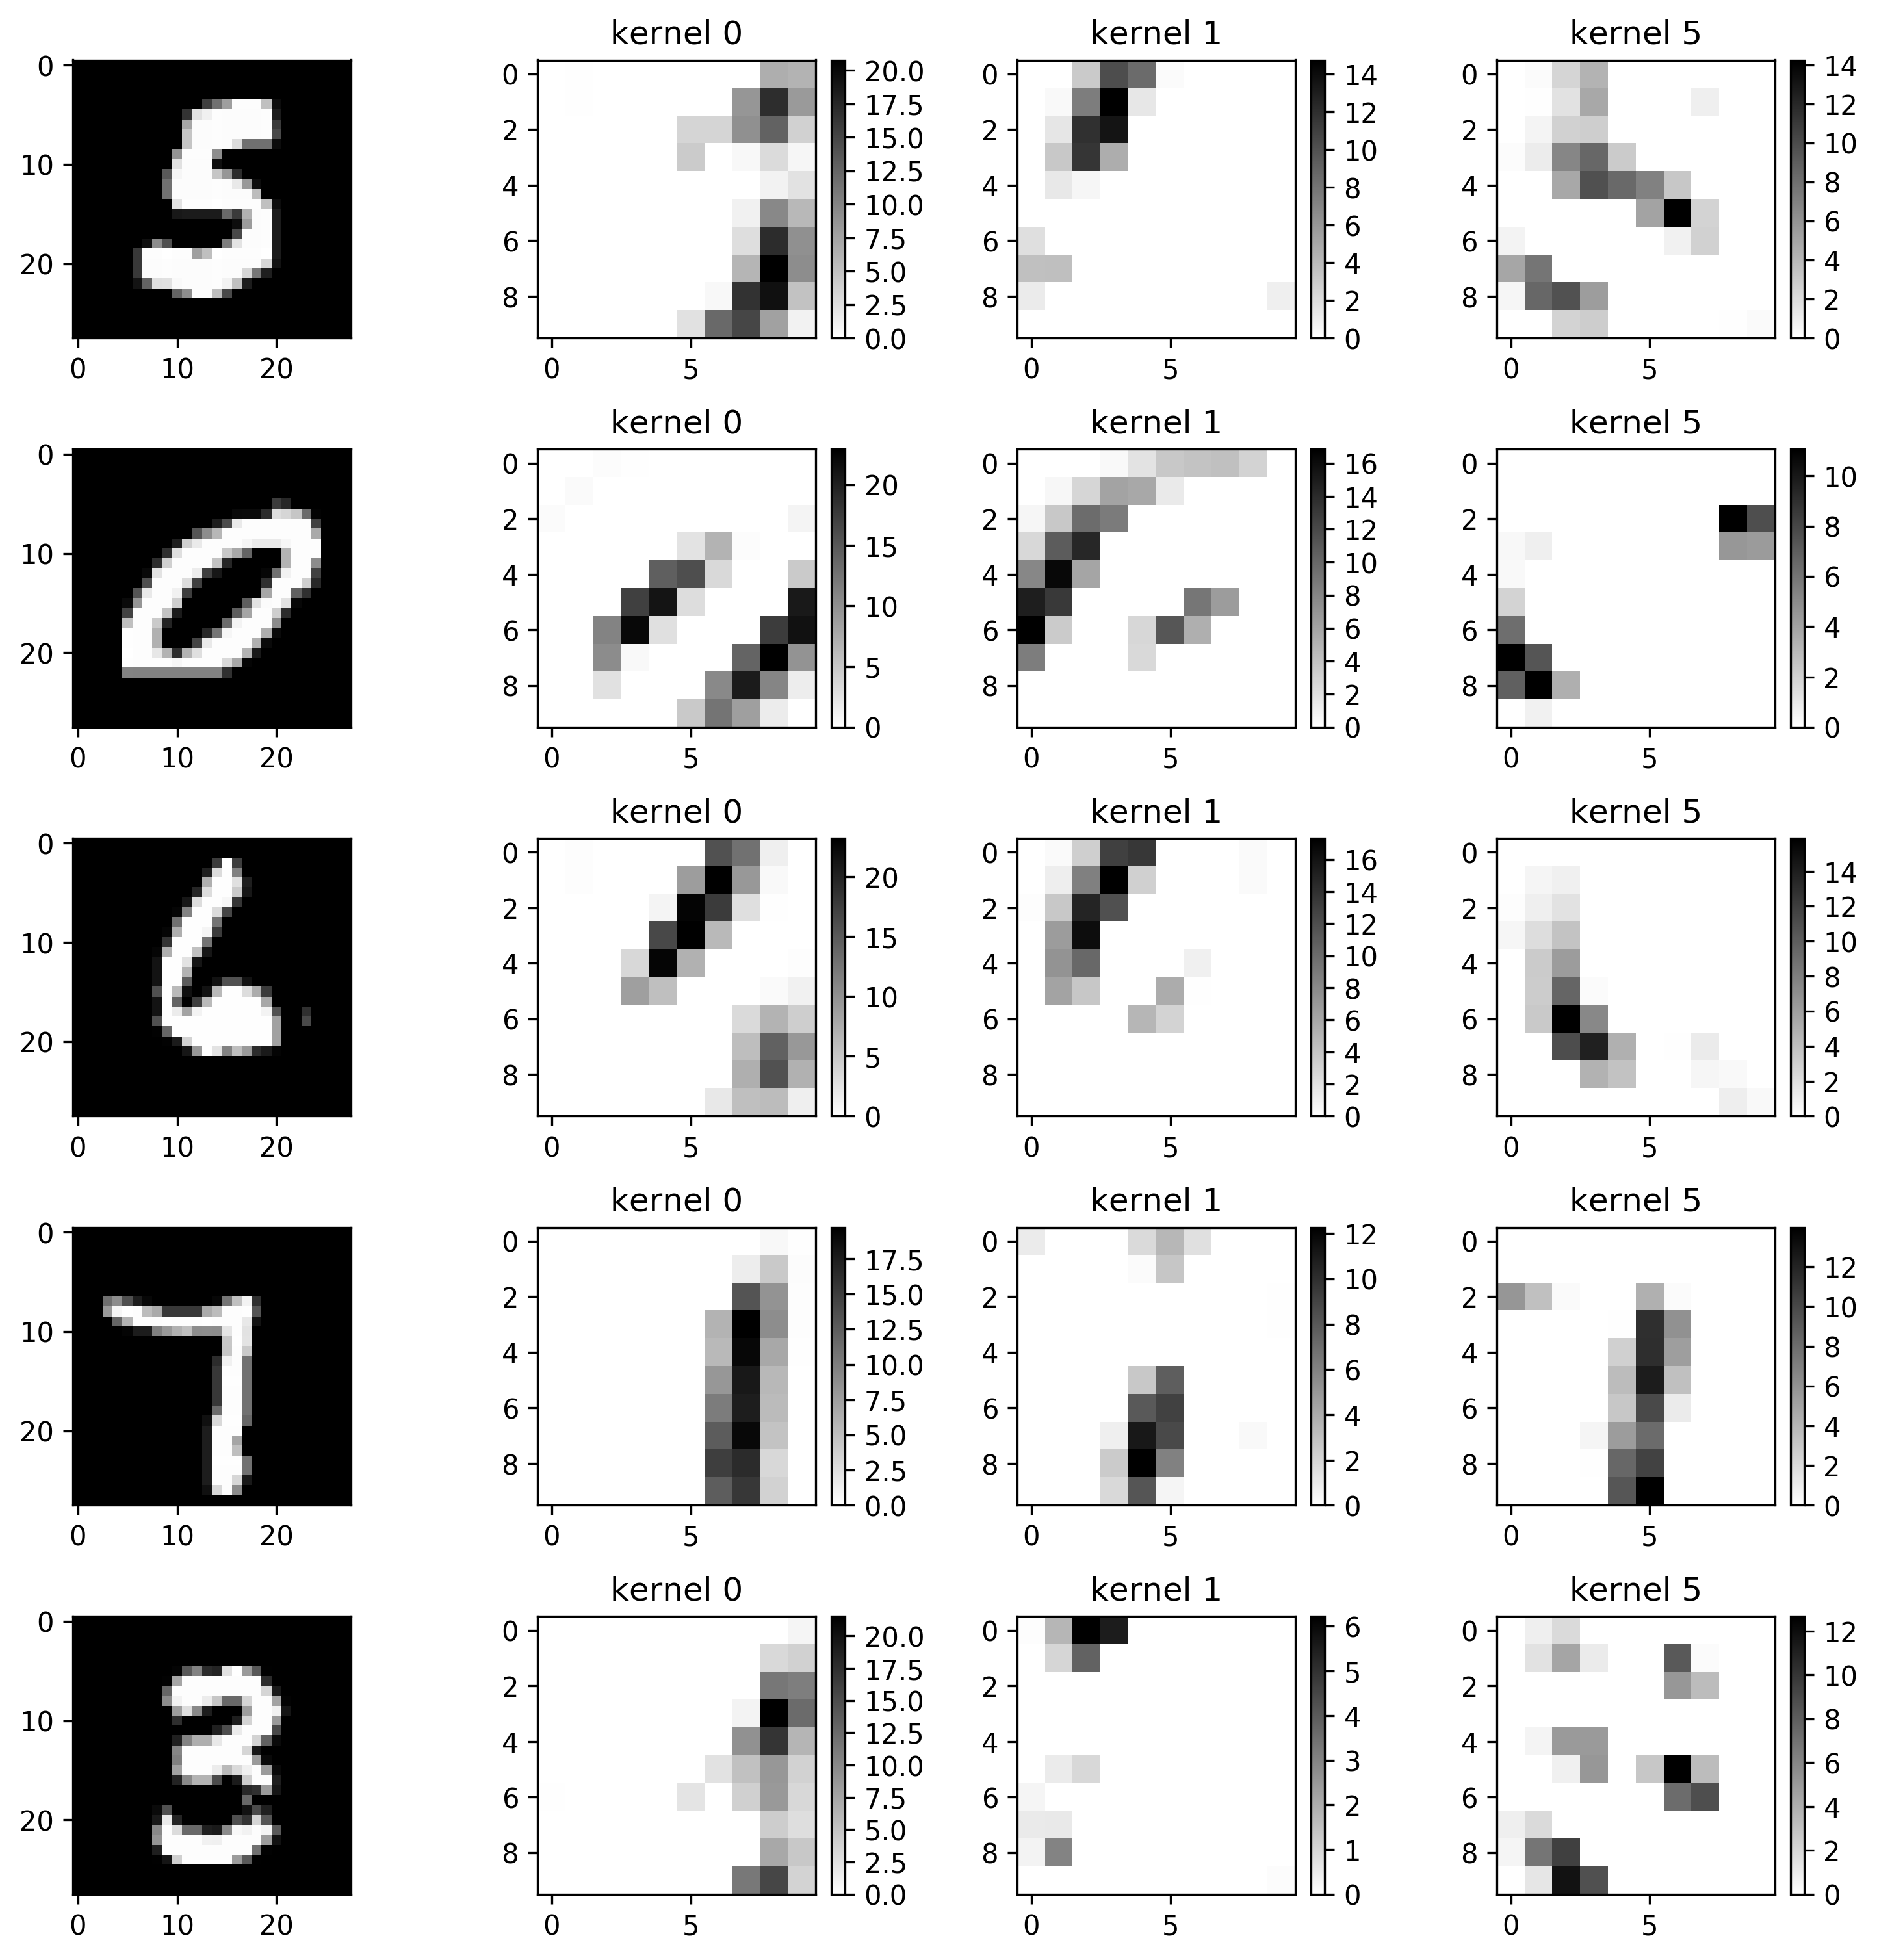

In [27]:
trunc_model = vis_conv.display_convolutions_per_filter(conv_model,'ConvLayer3',
                    input_images = train_data[1955:1960], figsize=(10,10), filter_indices = [0,1,5],
                    use_same_scaling=False, invert_cmap = True)

### VGG19

(4, 224, 224, 3)
Dimensions of output from layer block2_pool is (None, 56, 56, 128).
4 images will be displayed together with the selected 4 kernel indices


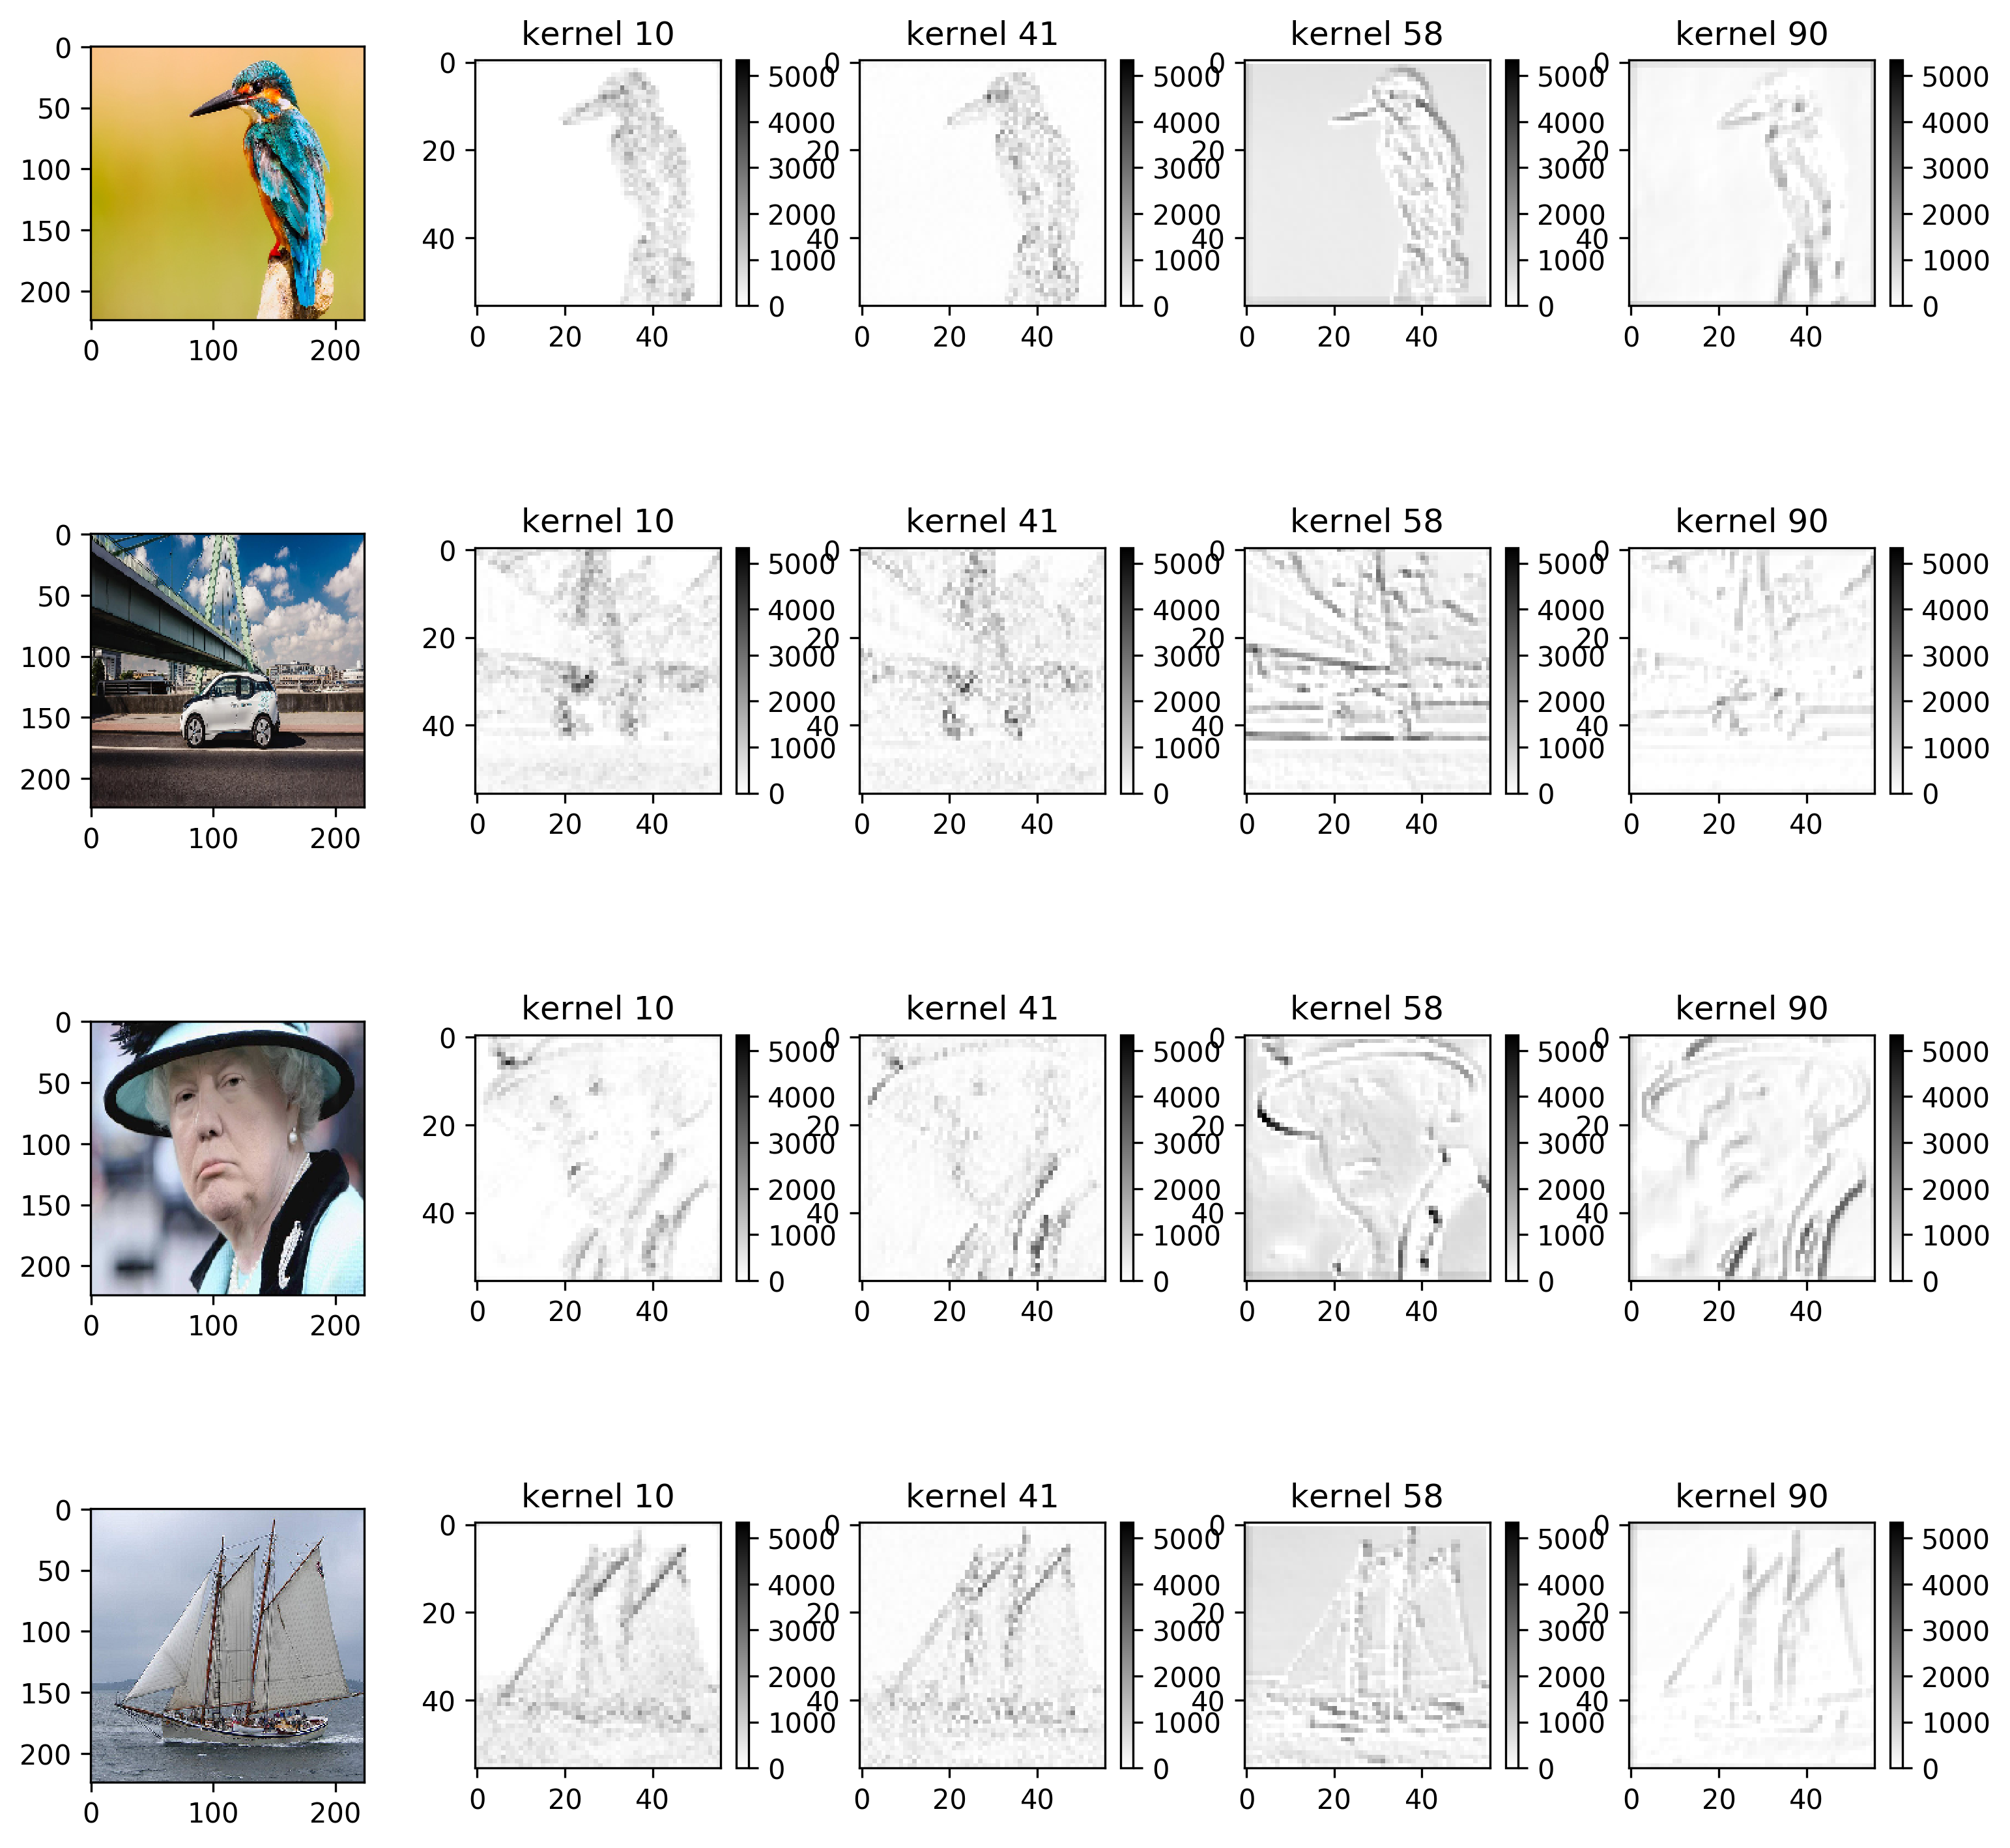

In [28]:
img = image.load_img('images/bird.jpeg', target_size=(224, 224))
x1 = np.uint8(image.img_to_array(img))
img = image.load_img('images/car.jpeg', target_size=(224, 224))
x2 = np.uint8(image.img_to_array(img))
img = image.load_img('images/queen.jpeg', target_size=(224, 224))
x3 = np.uint8(image.img_to_array(img))
img = image.load_img('images/boat.jpeg', target_size=(224, 224))
x4 = np.uint8(image.img_to_array(img))
images = np.stack([x1,x2,x3,x4])
print(images.shape)
trunc_model = vis_conv.display_convolutions_per_filter(base_model19,'block2_pool',
                    input_images = images, figsize=(10,10), filter_indices = None,
                    use_same_scaling=True, invert_cmap = True)

### InceptionV3

Dimensions of output from layer activation_63 is (None, 12, 12, 192).
4 images will be displayed together with the selected 3 kernel indices


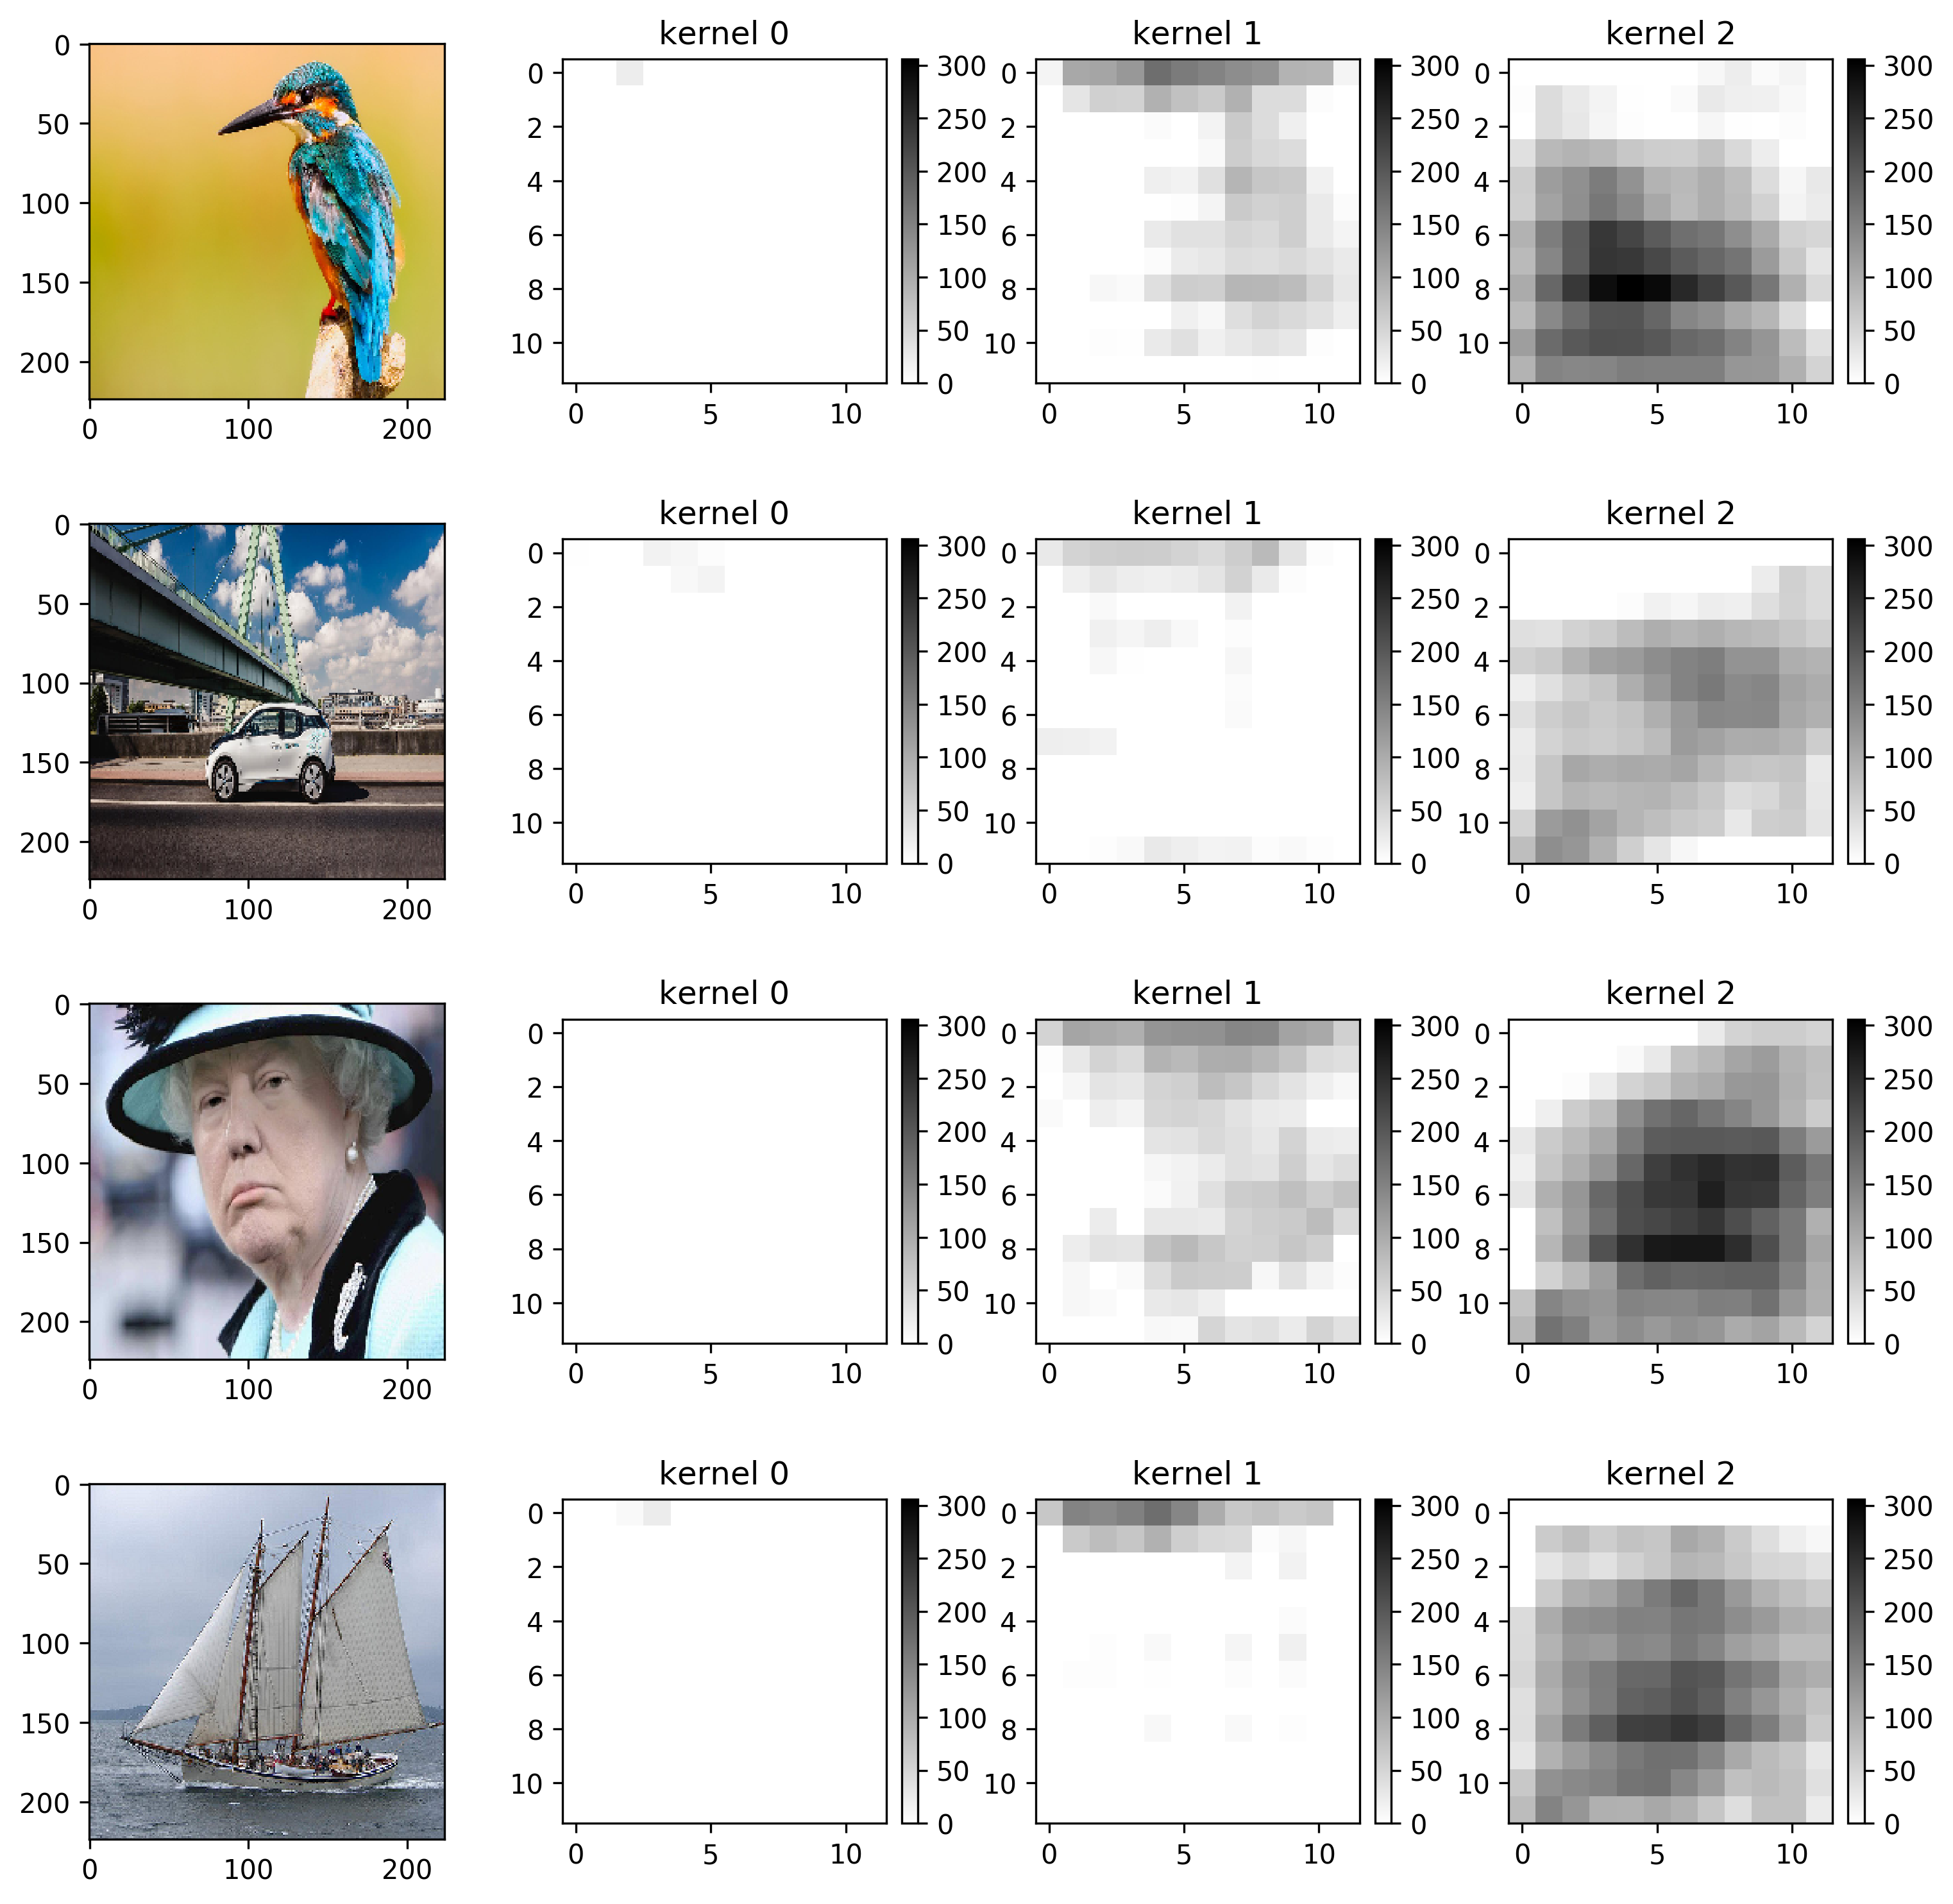

In [30]:
trunc_model = vis_conv.display_convolutions_per_filter(base_model_inception,'activation_63',
                    input_images = images, figsize=(10,10), filter_indices = [0,1,2],
                    use_same_scaling=True, invert_cmap = True, file_name = 'inceptionV3_kernels_conv2d_275.png')

If you have feedback (whatever) please drop me note.
[peter (at) neeb.info]